In [223]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from scipy import stats
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_absolute_error

### Error Functions

In [2]:
def mae_value(X_test,y_test, model, ):
    '''
    return MAE of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)

    #mae
    return mean_absolute_error(y_test, yhat)

def adjusted_r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    adjusted_r2 = 1 - (1-r2_score(y_test, yhat))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    #adjusted_r2 = 1 - (1-model.score(X_test,y_test))*((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    
    return adjusted_r2

def r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    return r2_score(y_test, yhat)

### Plotting and Coefficients

In [211]:
def plot_pred_vs_actual(X_test,y_test, model):
    '''
    plot y prediction against y test
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    #format plot
    plt.rcParams.update({'font.size': 12})    
    plt.title("Predicted VS Actual")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.figure(figsize=(10,5))
    
    #plot 
    plt.scatter(yhat, y_test, alpha=.2, color = '#3468bc')
    plt.plot(np.linspace(0,100000,1000), np.linspace(0,150000,1000))
    x_plot = np.linspace(0, 1, 100)
    
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(X,y)
    pred = rgr.predict(X)

    plt.subplot(1, 3, 1)
    plt.scatter(X,y)
    plt.plot(X, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
def get_feature_coefs(model,linear,X_train):
    #linear coefs
    if linear:
        print('Feature coefficient results: \n')
        for feature, coef in zip(X_train.columns, model.coef_):
            print(f'Coef of {feature} is : {coef:.2f}')

        return zip(X_train.columns, model.coef_)
    #poly coef
    else:
        print('Feature coefficient results: \n')
        for feature, coef in zip(model.get_feature_names(), model.coef_):
            print( f'Coef of {feature} is : {coef:.2f}')

        return zip(model.get_feature_names(), model.coef_)   

### Regression Functions with Cross Validation

In [238]:
def linear_regression_with_cv(X_train, y_train):
    '''
    print r2 val score and feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val r2 results
    r2_val = [] #collect the val r2 results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        r2_train.append(round(r2_value(X_train, y_train, lm), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, lm), 3))
        r2_val.append(round(r2_value(X_val, y_val, lm), 3))
        mae.append(round(mae_value(X_val, y_val, lm),3))
        
    #report results
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm

def polynomial_regression_with_cv(X_train, y_train, degree, interaction):
    '''
    print r2 val score and polynomial feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val results
    r2_val = [] #collect the validation results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #create polynomial features
        poly = PolynomialFeatures(degree=degree, interaction_only = interaction)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        #fit poly features to linear regression to training data
        lm_poly = LinearRegression()
        lm_poly.fit(X_train_poly, y_train)
        r2_adj.append(round(adjusted_r2_value(X_val_poly, y_val, lm_poly), 3))
        r2_val.append(round(r2_value( X_val_poly,y_val, lm_poly), 3))
        r2_train.append(round(r2_value( X_train_poly,y_train, lm_poly), 3))
        mae.append(round(mae_value(X_val_poly,y_val, lm_poly),3))
    
    #report results
    print(f'Results for {degree} degree, interaction_only = {interaction} polynomial regression:')
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm_poly

### Manual Lasso and Ridge

In [239]:
def manual_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### Manual Scaled Lasso and Ridge

In [233]:
def manual_scaled_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train_scaled, y_train)

        r2_val.append(round(r2_value( X_train_scaled, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_scaled_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train_scaled, y_train)

        r2_train.append(round(r2_value( X_train_scaled, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### LASSO and RidgeCV

In [206]:
def scaled_ridge_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):
    '''
    build ridge model, no features discarded and colinear features should have equal weight
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = RidgeCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

def scaled_lasso_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):  
    '''
    print optimized alpha of LassoCV val r2 train and r2 train mean 
    return model 
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = LassoCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

### Load Data

In [7]:
df = pd.read_pickle('../data/model_spec_sales_df.pkl')

df1 = df.loc[:,['Model','Class', 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                'length_in', 'width_in','height_in', 'wheelbase_in', 'Total_Sales']]
df1 = df1.dropna() #drop rows with null values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 324 to 4438
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          1209 non-null   object 
 1   Class          1209 non-null   object 
 2   doors          1209 non-null   object 
 3   passengers     1209 non-null   object 
 4   price          1209 non-null   float64
 5   speed_sec      1209 non-null   float64
 6   horsepower_hp  1209 non-null   float64
 7   drive          1209 non-null   object 
 8   mpg            1209 non-null   float64
 9   engine         1209 non-null   object 
 10  tank_gal       1209 non-null   float64
 11  length_in      1209 non-null   float64
 12  width_in       1209 non-null   float64
 13  height_in      1209 non-null   float64
 14  wheelbase_in   1209 non-null   float64
 15  Total_Sales    1209 non-null   float64
dtypes: float64(10), object(6)
memory usage: 160.6+ KB


In [8]:
#find unique models
df1['Model'].nunique()

301

## EDA

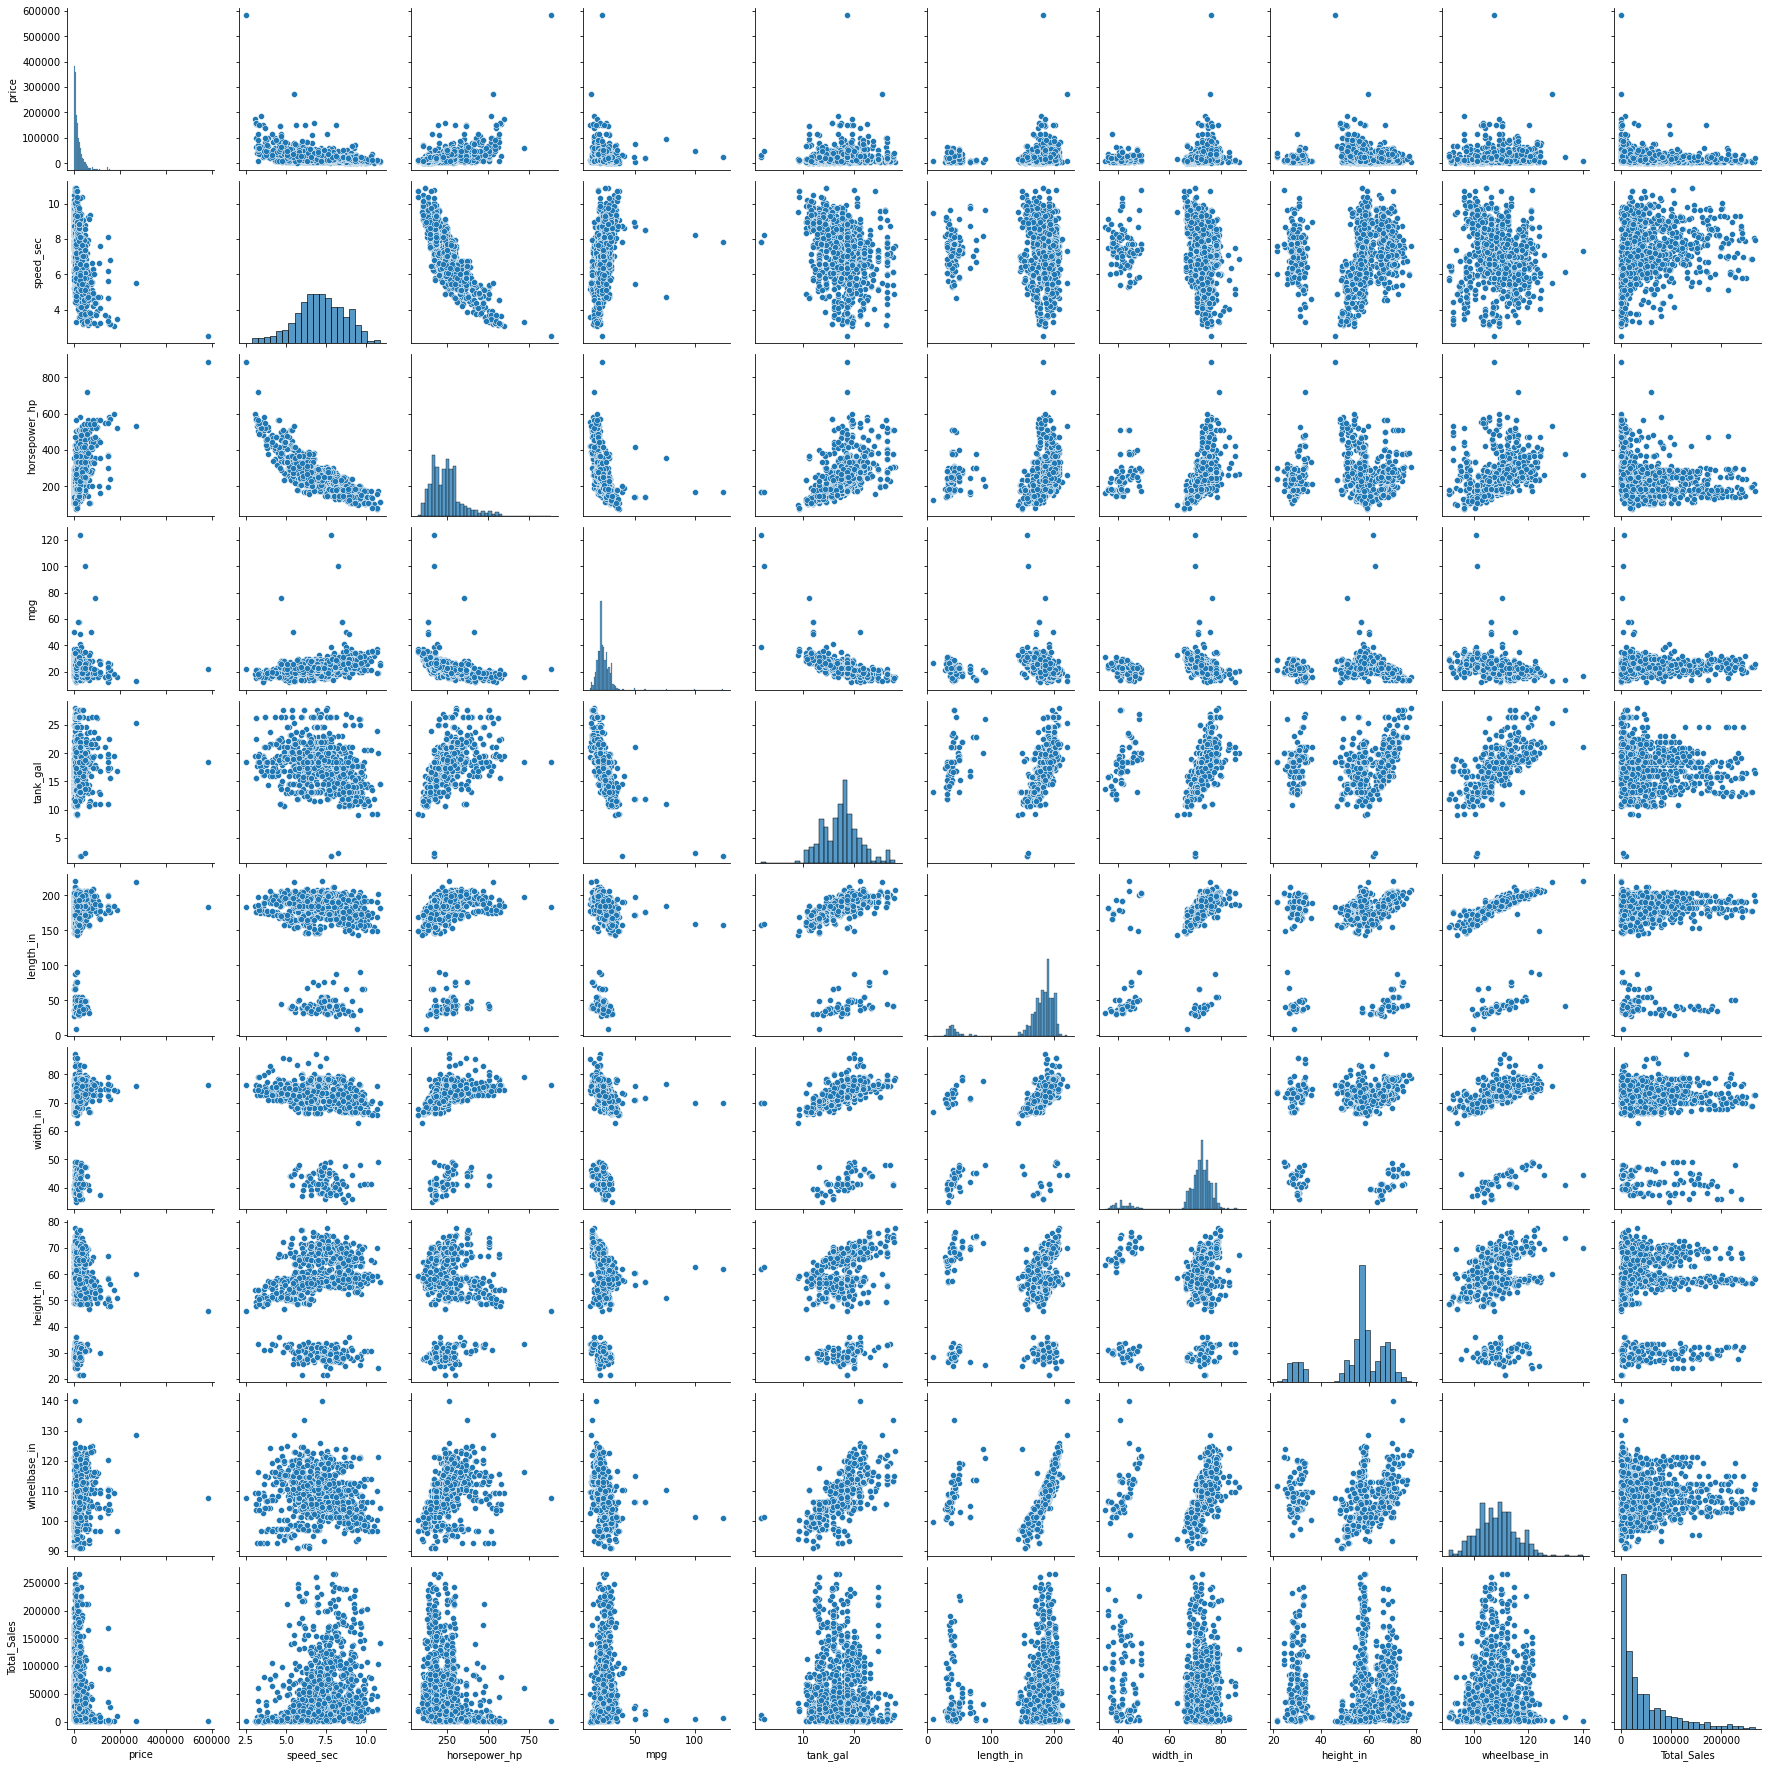

In [9]:
sns.pairplot(df1)

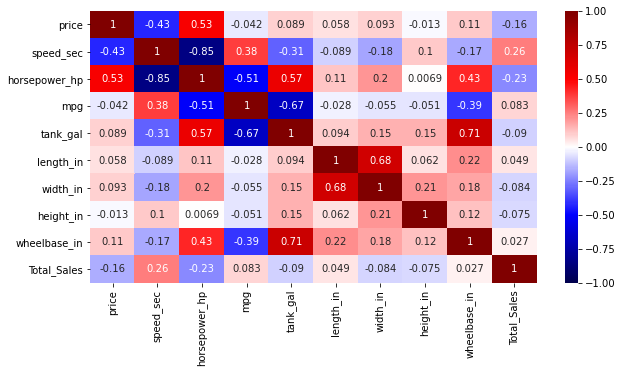

In [10]:
plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Check categorical features to see if it is related to Total Sales

<AxesSubplot:xlabel='passengers', ylabel='Count'>

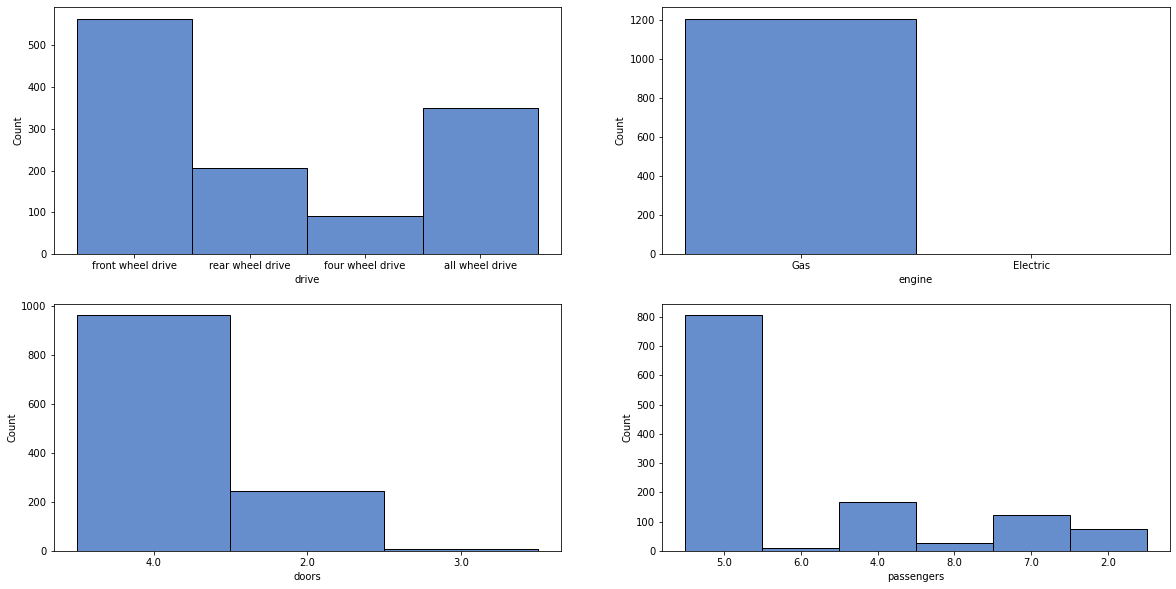

In [11]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, wspace=0.2)
plt.figure(figsize=(20,10))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.histplot(x=df1['drive'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.histplot(x=df1['engine'], color = '#3468bc')

ax = plt.subplot(gs[1, 0]) # row 0, col 3
sns.histplot(x=df1['doors'], color = '#3468bc')

ax = plt.subplot(gs[1, 1]) # row 0, col 3
sns.histplot(x=df1['passengers'], color = '#3468bc')

#### Intial Takeaways

###### What is the distribution of the target?

##### Are there any colinearities in the feartures?

* Price

##### What are the relationships between each features and the targets

So far there does not appear to be any obvious linear relationships between features and the target

# Modeling

### Baseline Model

define features(X) and Target(y)

In [12]:
X = df1[[ 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                 'length_in', 'width_in','height_in', 'wheelbase_in']]

y = df1['Total_Sales']

#X = pd.get_dummies(X, drop_first=True)
X = pd.get_dummies(X)

split data into train and test data 

In [13]:
# hold out 20% of the data for final testing
#change random state for new subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [14]:
#baseline linear model with cross validation
lm = linear_regression_with_cv(X_train,y_train)

Simple mean cv adjusted r^2 val score: 0.027 +- 0.025
Simple mean cv r^2 val score: 0.149 +- 0.022
Simple mean cv mae: 37783.631 +- 2715.898


In [15]:
#baseline polynomial model with interaction terms only
pm, X_test_pm = polynomial_regression_with_cv(X_train,y_train, 2, True, X_test)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv adjusted r^2 val score: 7.378 +- 2.702
Simple mean cv r^2 score: -2.602 +- 1.518
Simple mean cv mae: 48824.390 +- 6638.333


Severely negative R^2 score for polynomial regression tells us that the model is overfit and that evidence points towards a simple linear regression model.

In [16]:
#baseline lassocv
lasso, X_test_lasso = lasso_cv(5, 600, 700, 1, X_train, y_train, X_test, y_test)
#get coeficients to see if any zeroed out
get_feature_coefs(model=lasso,linear=True,X_train=X_train)

Alpha: 639
MAE value: 37054.88881695007
Adjusted r2 test score: 0.05194782950924948
R2 test score: 0.14635966391496735
Feature coefficient results: 

Coef of price is : -276.74
Coef of speed_sec is : 641.96
Coef of horsepower_hp is : -2263.32
Coef of mpg is : 0.00
Coef of tank_gal is : -6533.93
Coef of length_in is : 3375.18
Coef of width_in is : -2050.19
Coef of height_in is : -4549.93
Coef of wheelbase_in is : 1143.28
Coef of doors_2.0 is : -0.00
Coef of doors_3.0 is : -356.38
Coef of doors_4.0 is : 5285.70
Coef of passengers_2.0 is : -6513.90
Coef of passengers_4.0 is : -6640.75
Coef of passengers_5.0 is : 0.00
Coef of passengers_6.0 is : 637.46
Coef of passengers_7.0 is : 1858.96
Coef of passengers_8.0 is : 8768.29
Coef of drive_all wheel drive is : -2532.87
Coef of drive_four wheel drive is : 2936.60
Coef of drive_front wheel drive is : 4856.55
Coef of drive_rear wheel drive is : -0.00
Coef of engine_Electric is : -970.06
Coef of engine_Gas is : 0.00


In [237]:
manual_scaled_ridge_cv(X_train, y_train, 800)
manual_scaled_ridge_cv(X_train, y_train, 50)

Ridge regression results for aplpha = 800:
R^2 Val: 0.135,
Adjusted R^2 Val: 0.012,
MAE: 38454.8596,
Ridge regression results for aplpha = 50:
R^2 Val: 0.14700000000000002,
Adjusted R^2 Val: 0.0252,
MAE: 37814.1526,


MPG is zeroed

In [17]:
#baseline ridgecv
lasso, X_test_ridge = lasso_cv(5, 200, 300, 1, X_train, y_train, X_test, y_test)

Alpha: 299
MAE value: 36831.12499870503
Adjusted r2 test score: 0.0586110618654162
R2 test score: 0.15235933786222122


### Feature Engineering

Split length width and height into smaller and larger catergories

<AxesSubplot:xlabel='height_in', ylabel='Total_Sales'>

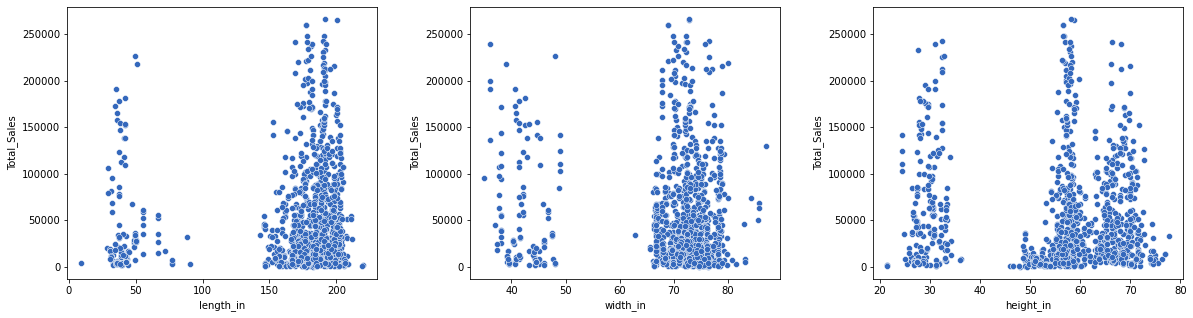

In [18]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3, wspace=0.3)
plt.figure(figsize=(20,5))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.scatterplot(x = df1['length_in'], y = df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.scatterplot(x=df1['width_in'], y=df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 2]) # row 0, col 3
sns.scatterplot(x=df1['height_in'], y=df1['Total_Sales'], color = '#3468bc')

In [19]:
#split length by 120 inches
X_train2 = X_train.copy()
X_test2 = X_test.copy()

X_train2['length_low'] = (X_train2['length_in']*(X_train2['length_in']<120))
X_test2['length_low'] = X_test2['length_in']*(X_test2['length_in']<120)

X_train2['length_hi'] = X_train2['length_in']*(X_train2['length_in']>=120)
X_test2['length_hi'] = X_test2['length_in']*(X_test2['length_in']>=120)

#split width by 55 inches
X_train2['width_low'] = (X_train2['width_in']*(X_train2['width_in']<55))
X_test2['width_low'] = (X_test2['width_in']*(X_test2['width_in']<55))

X_train2['width_hi'] = (X_train2['width_in']*(X_train2['width_in']>=55))
X_test2['width_hi'] = (X_test2['width_in']*(X_test2['width_in']>=55))

#split height by 40 inches
X_train2['height_low'] = (X_train2['height_in']*(X_train2['height_in']<40))
X_test2['height_low'] = X_test2['height_in']*(X_test2['height_in']<40)

X_train2['height_hi'] = X_train2['height_in']*(X_train2['height_in']>=40)
X_test2['height_hi'] = X_test2['height_in']*(X_test2['height_in']>=40)

#drop columns
X_train2 = X_train2.drop(labels=['length_in', 'width_in', 'height_in'], axis=1)
X_test2 = X_test2.drop(labels=['length_in', 'width_in', 'height_in'], axis=1)

current_r2 = 0.149
current_adj_r2 = 0.05
print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train2,y_train)
current_r2 = 0.158
current_adj_r2 = 0.044

Current r2 score: 0.149
Current adj r2 score: 0.05
Simple mean cv adjusted r^2 val score: 0.021 +- 0.020
Simple mean cv r^2 val score: 0.158 +- 0.017
Simple mean cv mae: 37487.280 +- 2729.259


Improved r2 but adj r2 went down because more features were added. Lets look at the relationshio between the 6 new columns

<ipython-input-20-544c092ad71e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Total_Sales'] = y_train.copy()


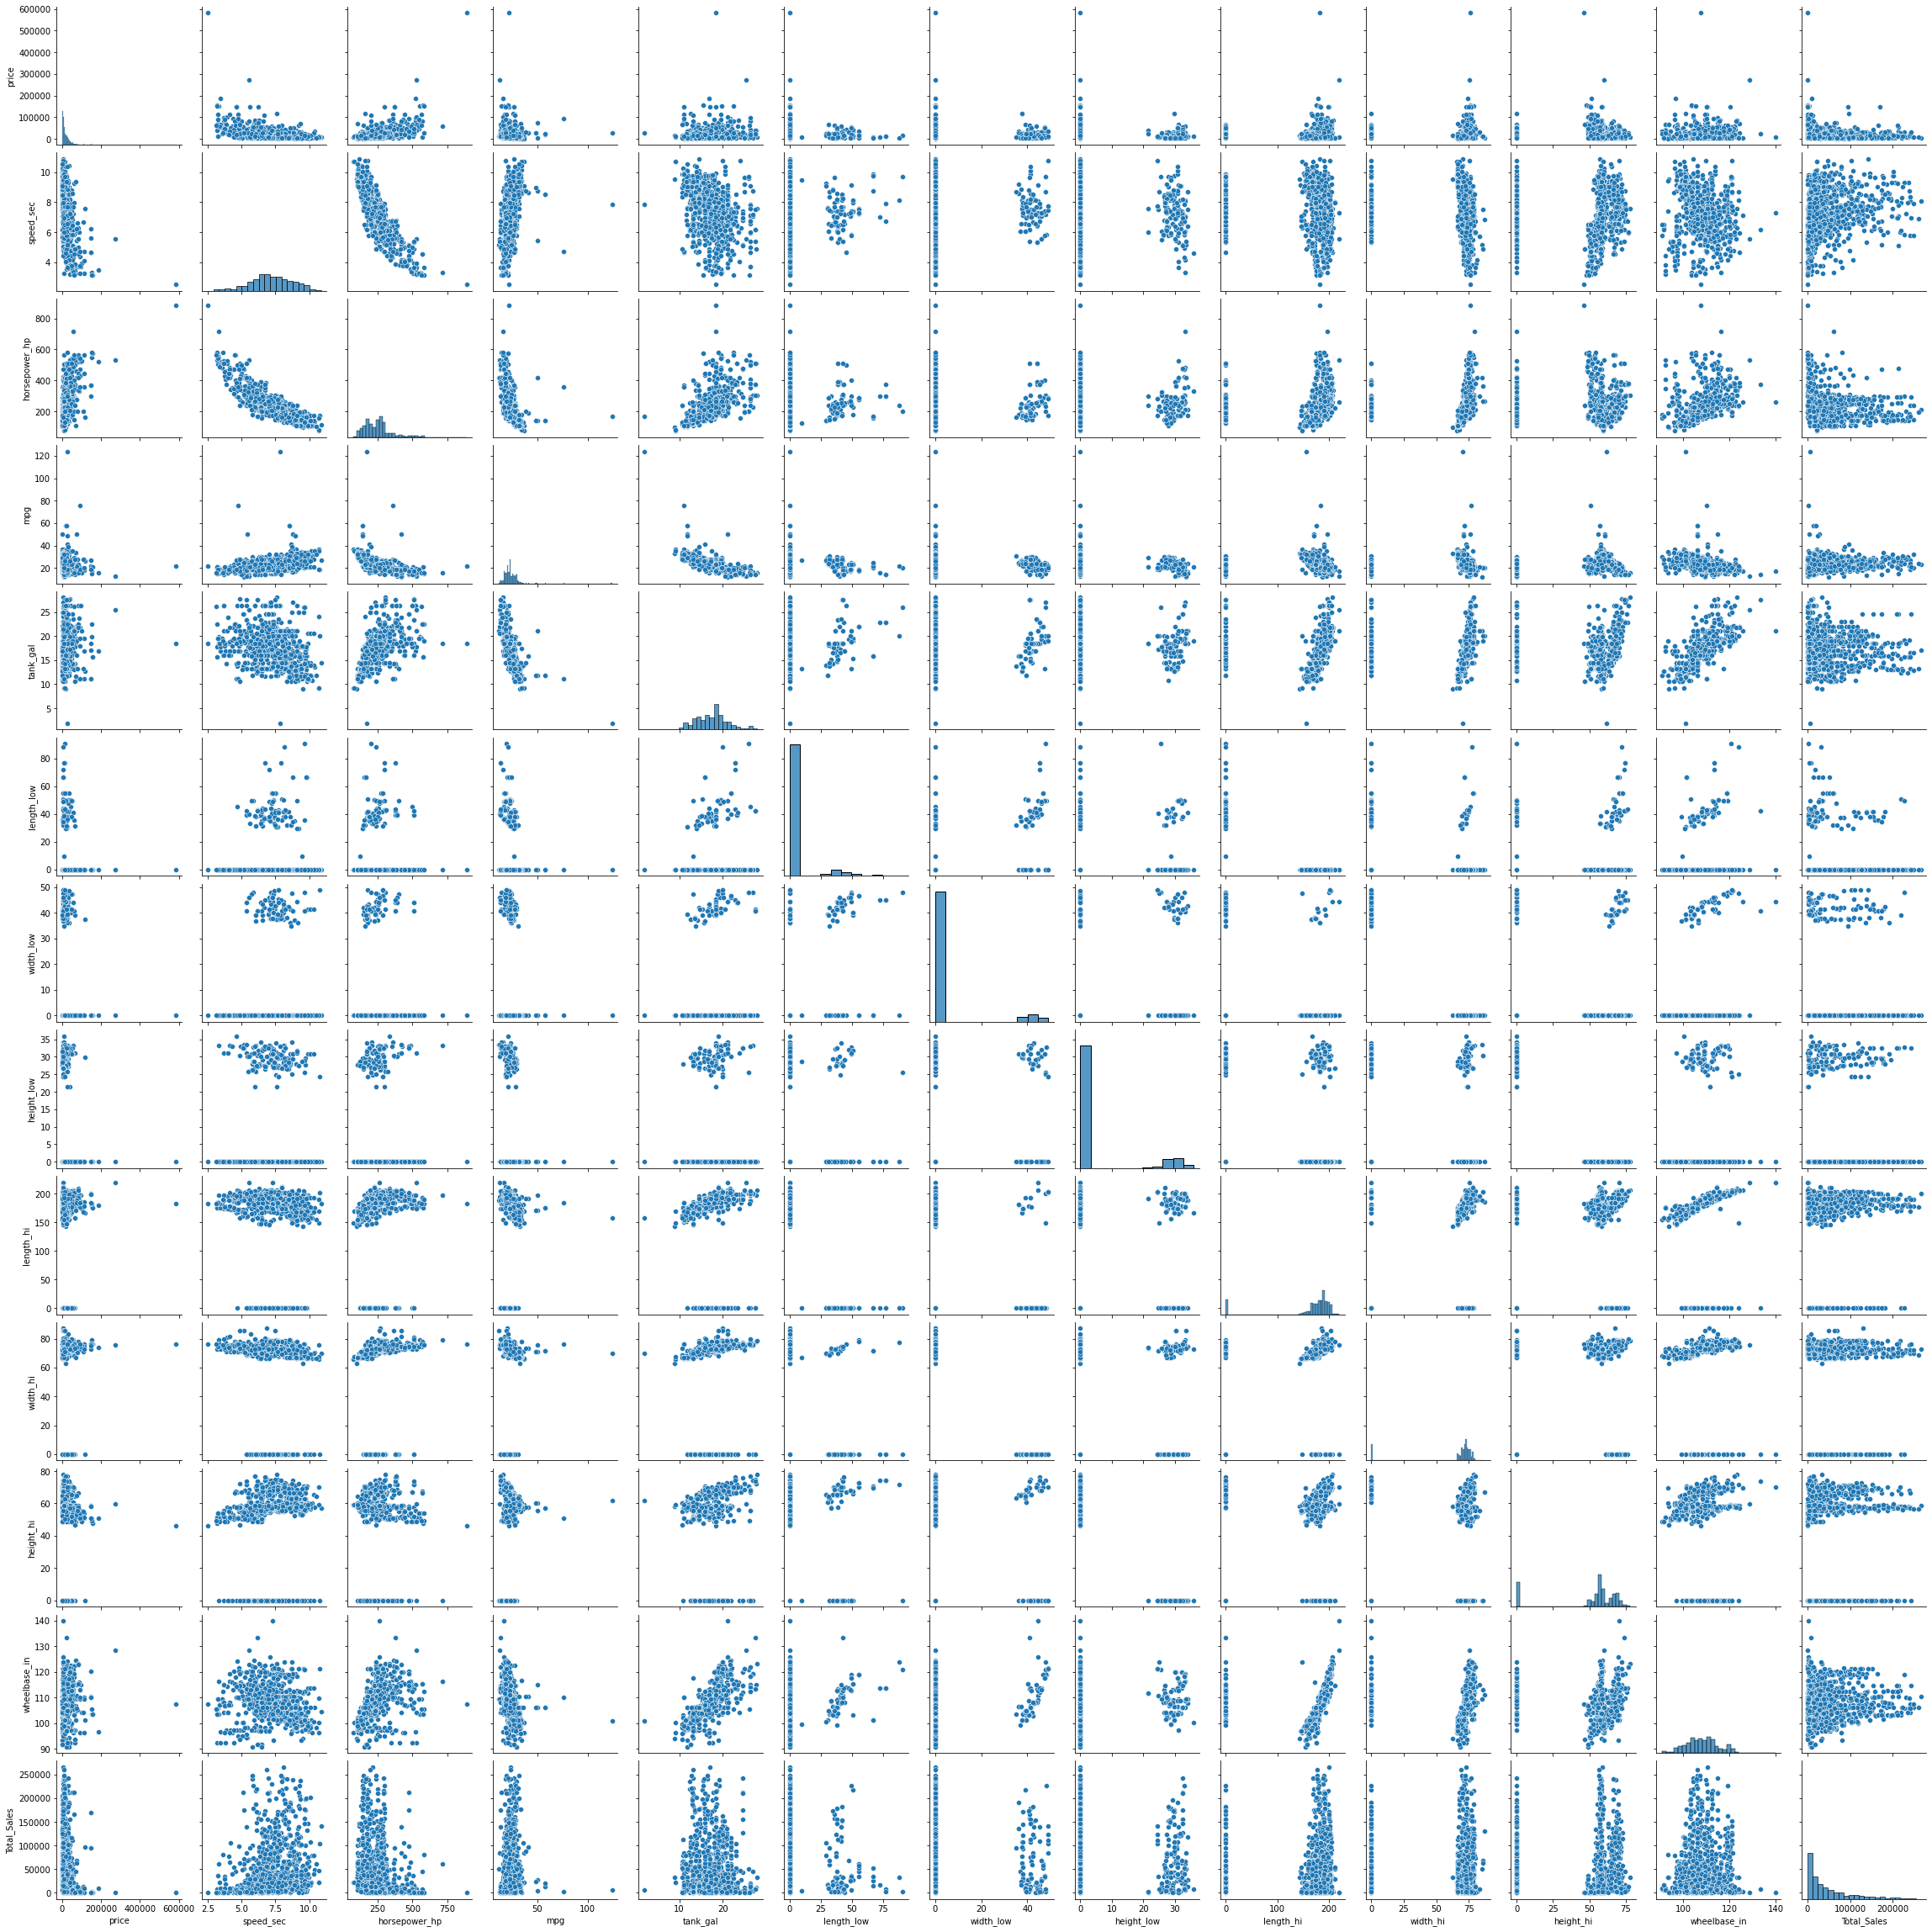

In [20]:
df3 = X_train2[[ 'price', 'speed_sec', 'horsepower_hp', 'mpg',  
                       'tank_gal', 'length_low', 'width_low','height_low', 'length_hi', 'width_hi','height_hi', 
                       'wheelbase_in']]
df3['Total_Sales'] = y_train.copy()
sns.pairplot(df3)

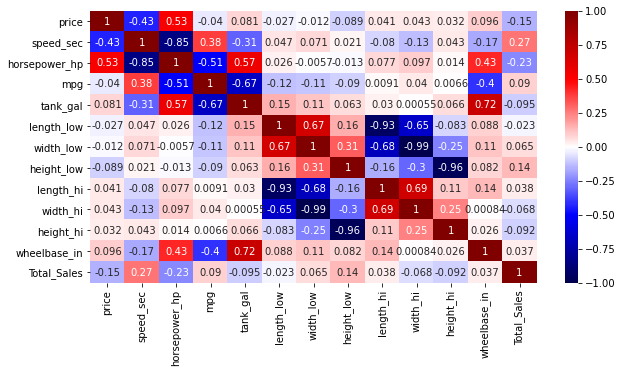

In [21]:
plt.figure(figsize=(10,5))
sns.heatmap(df3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

* tank_gal and wheel_base are colinear
* width_hi and length_hi are colinear
* width_low and length_low are colinear
* horsepower and tank_gal colinear

In [195]:
#Hi categories and low calories very highly correlated together, multiply and cobine into 2 size categories
# X_train3 = X_train2.copy()
# X_test3 = X_test2.copy()

# X_train3['size_low'] = X_train3['length_low']*X_train3['width_low']*X_train3['height_low']
# X_test3['size_low'] = X_test3['length_low']*X_test3['width_low'] *X_test3['height_low']

# X_train3['size_hi'] = X_train3['length_hi']*X_train3['width_hi'] *X_train3['height_hi']
# X_test3['size_hi'] = X_test3['length_hi']*X_test3['width_hi'] *X_test3['height_hi']

# #drop columns
# X_train3 = X_train3.drop(labels=['length_hi', 'width_hi', 'height_hi', 'length_low', 'width_low', 'height_low'], axis=1)
# X_test3 = X_test3.drop(labels=['length_hi', 'width_hi', 'height_hi', 'length_low', 'width_low', 'height_low'], axis=1)

# print(f'Current r2 score: {current_r2}')
# print(f'Current adj r2 score: {current_adj_r2}')
# lm2 = linear_regression_with_cv(X_train3,y_train)
# current_r2 = 0.146
# current_adj_r2 = 0.052

Lowered our adjuested r2 score and made model more simple, but decreased our regular r2 score

<ipython-input-23-d9b16e2573ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Total_Sales'] = y_train.copy()


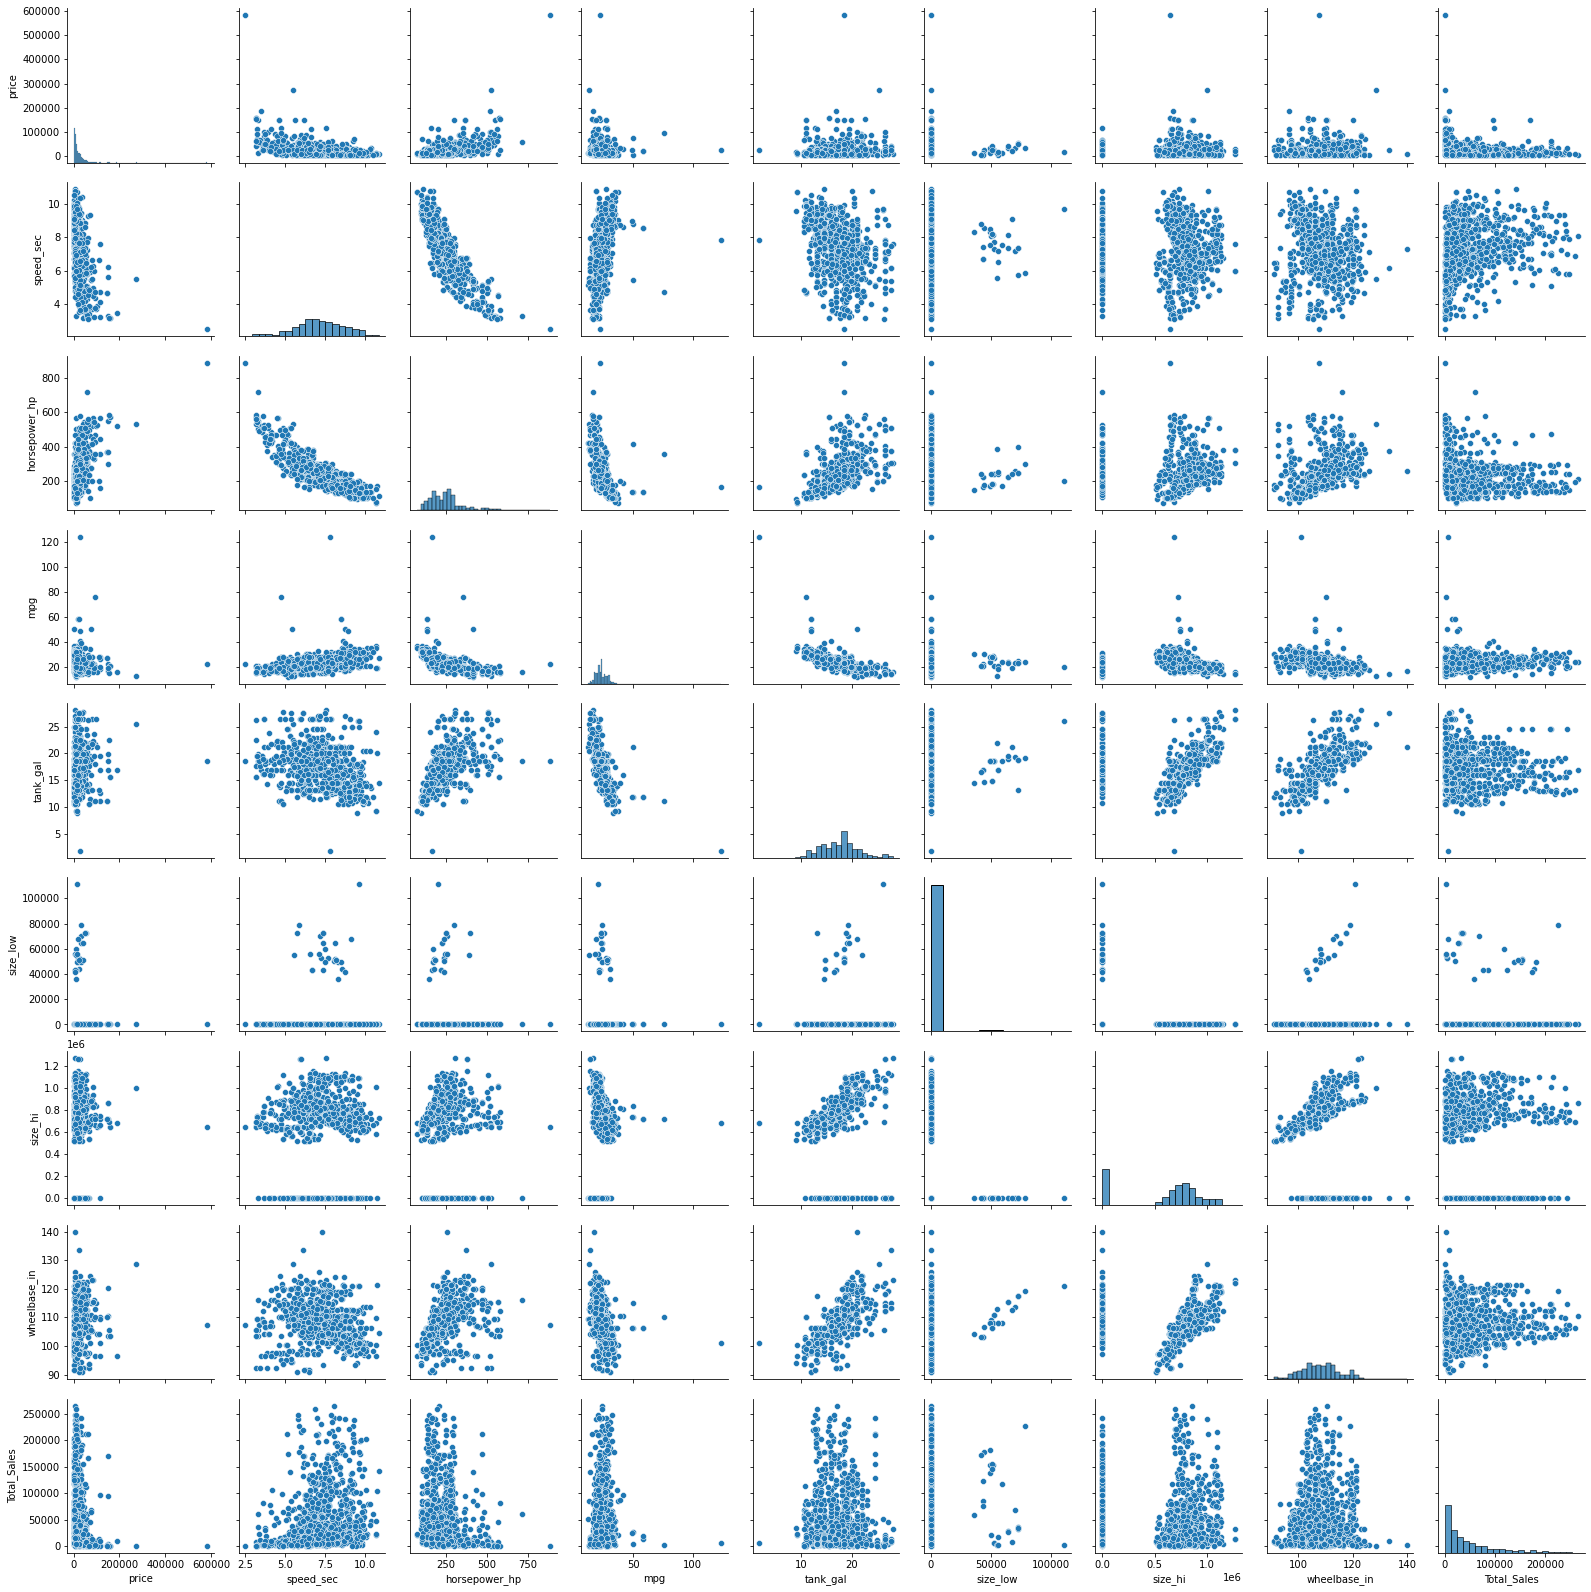

In [23]:
df4 = X_train3[[ 'price', 'speed_sec', 'horsepower_hp', 'mpg',  
                       'tank_gal', 'size_low', 'size_hi',  'wheelbase_in']]
df4['Total_Sales'] = y_train.copy()
sns.pairplot(df4)

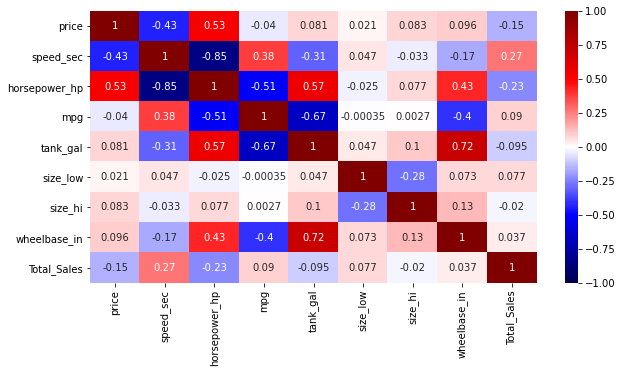

In [24]:
plt.figure(figsize=(10,5))
sns.heatmap(df4.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [196]:
X_train4 = X_train2.copy()
X_test4 = X_test2.copy()

#drop mpg and passengers_4.0 per baseline lassocv model
X_train4 = X_train4.drop(labels=['mpg', 'drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0', 'doors_3.0'], axis=1)
X_test4 = X_test4.drop(labels=['mpg', 'drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0', 'doors_3.0'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.151
current_adj_r2 = 0.068

Current r2 score: 0.186
Current adj r2 score: 0.032
Simple mean cv adjusted r^2 val score: 0.063 +- 0.022
Simple mean cv r^2 val score: 0.166 +- 0.020
Simple mean cv mae: 37412.320 +- 2799.296


Increase in both adjusted r2 and regular r2 val scores when MPG, passengers_4.0, rear whell drive, and doors_3.0 is dropped

In [197]:
#drop wheelbase because it is collinear with tank_gal
X_train4 = X_train4.drop(labels=['wheelbase_in'], axis=1)
X_test4 = X_test4.drop(labels=['wheelbase_in'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.149
current_adj_r2 = 0.072

Current r2 score: 0.151
Current adj r2 score: 0.068
Simple mean cv adjusted r^2 val score: 0.070 +- 0.022
Simple mean cv r^2 val score: 0.166 +- 0.020
Simple mean cv mae: 37378.679 +- 2819.089


In [198]:
#drop speed_sec because it is collinear horsepower_hp
X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)
X_test4 = X_test4.drop(labels=['speed_sec'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.151
current_adj_r2 = 0.079

Current r2 score: 0.149
Current adj r2 score: 0.072
Simple mean cv adjusted r^2 val score: 0.077 +- 0.021
Simple mean cv r^2 val score: 0.168 +- 0.019
Simple mean cv mae: 37284.864 +- 2838.372


In [199]:
#drop speed_sec because it is collinear horsepower_hp
X_train4 = X_train4.drop(labels=['horsepower_hp'], axis=1)
X_test4 = X_test4.drop(labels=['horsepower_hp'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.152
current_adj_r2 = 0.086

Current r2 score: 0.151
Current adj r2 score: 0.079
Simple mean cv adjusted r^2 val score: 0.083 +- 0.022
Simple mean cv r^2 val score: 0.169 +- 0.020
Simple mean cv mae: 37143.221 +- 2840.276


Regular r2 value stayed the same and adjusted r2 increased after the 2 columns were dropped. 

In [200]:
# df5 = X_train4[[ 'price', 'tank_gal', 'size_low', 'size_hi']]
# #df5 = X_train4
# df5['Total_Sales'] = y_train.copy()
# sns.pairplot(df5)

Perform BoxCox transformation on non-normally distributed features

In [201]:
X_train5 = X_train4.copy()
X_test5 = X_test4.copy()

# transform price feature into normal distribution data & save lambda value 
fitted_train_data, fitted_train_lambda = stats.boxcox(X_train5['price']) 
fitted_test_data, fitted_test_lambda = stats.boxcox(X_test5['price']) 
X_train5['price'] = np.log(fitted_train_data)
X_test5['price'] = fitted_test_data

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train5,y_train)
current_r2 = 0.153
current_adj_r2 = 0.087

Current r2 score: 0.152
Current adj r2 score: 0.086
Simple mean cv adjusted r^2 val score: 0.084 +- 0.021
Simple mean cv r^2 val score: 0.170 +- 0.019
Simple mean cv mae: 37068.955 +- 2849.044


In [202]:
# df6 = X_train5[[ 'price', 'tank_gal', 'size_low', 'size_hi']]
# df6['Total_Sales'] = y_train.copy()
# sns.pairplot(df6)

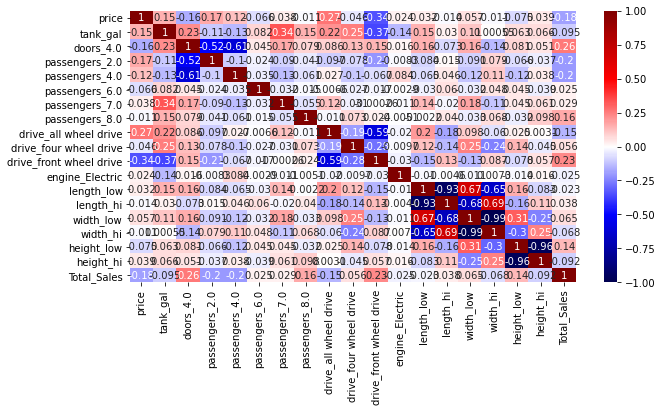

In [188]:
df7 = X_train5.copy()
df7['Total_Sales'] = y_train.copy()
plt.figure(figsize=(10,5))
sns.heatmap(df7.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [190]:
X_train6 = X_train5.copy()
X_test6 = X_test5.copy()

#Insert interaction terms for large size
# X_train6['large*elec'] = X_train6['size_hi']*X_train6['engine_Electric']
# X_train6['large*awd'] = X_train6['size_hi']*X_train6['drive_all wheel drive']
# X_train6['large*8p'] = X_train6['size_hi']*X_train6['passengers_8.0']
# X_train6['large*4p'] = X_train6['size_hi']*X_train6['passengers_4.0']
# X_train6['large*4d'] = X_train6['size_hi']*X_train6['doors_4.0']

# X_test6['large*elec'] = X_test6['size_hi']*X_test6['engine_Electric']
# X_test6['large*awd'] = X_test6['size_hi']*X_test6['drive_all wheel drive']
# X_test6['large*8p'] = X_test6['size_hi']*X_test6['passengers_8.0']
# X_test6['large*4p'] = X_test6['size_hi']*X_test6['passengers_4.0']
# X_test6['large*4d'] = X_test6['size_hi']*X_test6['doors_4.0']

# #Insert interaction terms for small size
# X_train6['small*7p'] = X_train6['size_low']*X_train6['passengers_7.0']
# X_train6['small*tank'] = X_train6['size_low']*X_train6['tank_gal']

# X_test6['small*7p'] = X_test6['size_low']*X_test6['passengers_7.0']
# X_test6['small*tank'] = X_test6['size_low']*X_test6['tank_gal']

#Insert interaction terms for front wheel drive
X_train6['frwd*4d'] = X_train6['drive_front wheel drive']*X_train6['doors_4.0']

X_test6['frwd*4d'] = X_test6['drive_front wheel drive']*X_test6['doors_4.0']

#Insert interaction terms for four wheel drive
X_train6['fowd*8p'] = X_train6['drive_four wheel drive']*X_train6['passengers_8.0']
X_train6['fowd*tank'] = X_train6['drive_four wheel drive']*X_train6['tank_gal']

X_test6['fowd*8p'] = X_test6['drive_four wheel drive']*X_test6['passengers_8.0']
X_test6['fowd*tank'] = X_test6['drive_four wheel drive']*X_test6['tank_gal']

#Insert interaction terms for all wheel drive
X_train6['awd*2p'] = X_train6['drive_all wheel drive']*X_train6['passengers_2.0']
X_train6['awd*4d'] = X_train6['drive_all wheel drive']*X_train6['doors_4.0']

X_test6['awd*2p'] = X_test6['drive_all wheel drive']*X_test6['passengers_2.0']
X_test6['awd*4d'] = X_test6['drive_all wheel drive']*X_test6['doors_4.0']


#Insert interaction terms for 8 passengers
X_train6['8p*tank'] = X_train6['passengers_8.0']*X_train6['tank_gal']

X_test6['8p*tank'] = X_test6['passengers_8.0']*X_test6['tank_gal']

#Insert interaction terms for 8 passengers
X_train6['7p*4d'] = X_train6['passengers_7.0']*X_train6['doors_4.0']
X_train6['7p*tank'] = X_train6['passengers_7.0']*X_train6['tank_gal']

X_test6['7p*4d'] = X_test6['passengers_7.0']*X_test6['doors_4.0']
X_test6['7p*tank'] = X_test6['passengers_7.0']*X_test6['tank_gal']

#Insert interaction terms for 4 passengers
X_train6['4p*price'] = X_train6['passengers_4.0']*X_train6['price']

X_test6['4p*price'] = X_test6['passengers_4.0']*X_test6['price']

#Insert interaction terms for 2 passengers
X_train6['2p*tank'] = X_train6['passengers_2.0']*X_train6['tank_gal']

X_test6['2p*tank'] = X_test6['passengers_2.0']*X_test6['tank_gal']

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train6,y_train)
current_r2 = 0.186
current_adj_r2 = 0.032

Current r2 score: 0.153
Current adj r2 score: 0.087
Simple mean cv adjusted r^2 val score: 0.045 +- 0.016
Simple mean cv r^2 val score: 0.184 +- 0.014
Simple mean cv mae: 36452.997 +- 2766.502


In [193]:
#model = ridge_cv(10, 0, 100, 1, X_train2, y_train, X_test2, y_test) 

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.39106e-32): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.42721e-32): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.38517e-32): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33693e-32): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridg

Alpha: 5
MAE value: 36108.68857572268
Adjusted r2 test score: 0.10724863492066095
R2 test score: 0.17392716011330867


In [212]:
#create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train4)
X_test_poly = poly.transform(X_test4)
model2 = lasso_cv(10, 150, 200, 0.5, X_train_poly, y_train, X_test_poly, y_test) 
coef = get_feature_coefs(model=model2,linear=False,X_train=X_train_poly)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 556584526.0212402, tolerance: 264279422.3839361
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 827833164.3789062, tolerance: 261873899.90799958
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584431749.5700684, tolerance: 275829343.30328333
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/l

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 840561977.1508789, tolerance: 273254355.53955823
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 739561762.6066895, tolerance: 261042202.9712759
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493855999.2036133, tolerance: 271293438.7088551
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/li

Alpha: 183.5
MAE value: 34571.92556557668
Adjusted r2 test score: -1.694291572832046
R2 test score: 0.22860531732194522
Feature coefficient results: 



/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 975166004.416748, tolerance: 296924503.8114792
  model = cd_fast.enet_coordinate_descent(


AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [ ]:
X_train5['tank_mpg'] = (X_train5['tank_gal'])*(X_train5['mpg'])*(X_train5['wheelbase_in'])
# X_train5['speed_log'] = np.log(X_train5['speed_sec'])
X_train5 = X_train5.drop(labels=['tank_gal'], axis=1)
X_train5 = X_train5.drop(labels=['mpg'], axis=1)
X_train5 = X_train5.drop(labels=['horsepower_hp'], axis=1)

X_test5['speed_hp'] = (X_test5['speed_sec'])*(X_test5['horsepower_hp'])
X_test5 = X_test5.drop(labels=['speed_sec'], axis=1)
X_test5 = X_test5.drop(labels=['horsepower_hp'], axis=1)
X_train5 = X_train5.drop(labels=['wheelbase_in'], axis=1)
# #X_test5 = X_test5.drop(labels=['speed_sec'], axis=1)

X_test5['tank_mpg'] = (X_test5['tank_gal'])*(X_test5['mpg'])*(X_test5['wheelbase_in'])
X_test5 = X_test5.drop(labels=['tank_gal'], axis=1)
X_test5 = X_test5.drop(labels=['mpg'], axis=1)
X_test5 = X_test5.drop(labels=['wheelbase_in'], axis=1)

simple_linear_regression(X_train5,y_train)
# print(max_r2)
# #sns.scatterplot(x='Log(Followers)', y='Popularity', data=df_hiphop_feature_eng)

# sns.scatterplot(X_train5['speed_log'], y_train)
# max_r2 = 0.19441360490547865

In [ ]:
#add non linear relationship for speed
X_train6 = X_train5.copy()
X_test6 = X_test5.copy()

# #X_train4['speed_4sqr'] = 0.25**X_train4['speed_sec']
# X_train6['mpg_sqr'] = X_train6['mpg']**2

# #X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)

# X_test6['mpg_sqr'] = X_test6['mpg']**2
# #X_test4 = X_test4.drop(labels=['speed_sec'], axis=1)

# simple_linear_regression(X_train6,y_train)
# print(max_r2)
# #sns.scatterplot(x='Log(Followers)', y='Popularity', data=df_hiphop_feature_eng)
# sns.scatterplot(X_train6['mpg_sqr'], y_train)

# max_r2 = 0.20608026091337384

In [ ]:
#add non linear relationship for speed
# X_train5 = X_train.copy()
# #X_train4['speed_sq'] = X_train4['speed_sec']**3 - X_train4['speed_sec']
# #X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)
# simple_linear_regression(X_train4,y_train)
# print(max_r2)

In [ ]:
model = simple_linear_regression(X_train5,y_train)
mae = mae_value_plot(X_test5,y_test, model)
print(r2_value( X_test5,y_test, model), mae)

In [ ]:
model = scaled_linear_regression(X_train4,y_train)
mae = mae_value_plot(X_test4,y_test, model)
print(r2_value( X_test4,y_test, model), mae)

LassoCV

In [ ]:
lasso_reg(10, 100, 200, 1, X_train5, y_train, X_test5, y_test) 

In [ ]:
polynomial_lasso_reg(10, 300, 400, 1, X_train4, y_train, X_test4, y_test) 


In [ ]:
alpha = 791
mae = 34481.79189953941
r2 = 0.2401656496992064

In [ ]:
polynomial_lasso_reg(10, 700, 800, 1, X_train4, y_train, X_test4, y_test) 